In [1]:
import tensorflow as tf
import nltk
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import pandas as pd

2025-06-25 17:33:14.857399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750865594.870168  125041 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750865594.874146  125041 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750865594.883816  125041 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750865594.883834  125041 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750865594.883836  125041 computation_placer.cc:177] computation placer alr

In [2]:
from utils_display import pc

In [3]:
random.seed(421)

### Text, corpus, and vocabulary

In [4]:
# Text
with open("datasets/animal_farm_george_orwell.txt", "r") as fid:
    text = fid.read()

In [5]:
# Corpus
sentences = nltk.tokenize.sent_tokenize(text)
random.shuffle(sentences)

corpus = []
for sentence in sentences:
    sentence = sentence.lower()
    sentence = re.findall(r'\b\w+\b', sentence) 
    corpus.append(sentence)

number_of_sentences = len(corpus)
pc("Number of sentences", number_of_sentences)

Number of sentences: 1637


In [6]:
train_split = 0.9
number_of_train_sentences = int(train_split * number_of_sentences)
number_of_validation_sentences = number_of_sentences - number_of_train_sentences
pc("Number of train sentences", number_of_train_sentences)
pc("Number of validation sentences", number_of_validation_sentences)

Number of train sentences: 1473
Number of validation sentences: 164


In [7]:
number_of_example_sentences = 4
for index in range(number_of_example_sentences):
    print(index)
    print(sentences[index])
    print(corpus[index])
    print("-"*64)

0
From now onwards Animal Farm would engage in trade with the neighbouring farms: not, of course, for any commercial purpose, but simply in order to obtain certain materials which were urgently necessary.
['from', 'now', 'onwards', 'animal', 'farm', 'would', 'engage', 'in', 'trade', 'with', 'the', 'neighbouring', 'farms', 'not', 'of', 'course', 'for', 'any', 'commercial', 'purpose', 'but', 'simply', 'in', 'order', 'to', 'obtain', 'certain', 'materials', 'which', 'were', 'urgently', 'necessary']
----------------------------------------------------------------
1
Finally there came a night when the gale was so violent that the farm buildings rocked on their foundations and several tiles were blown off the roof of the barn.
['finally', 'there', 'came', 'a', 'night', 'when', 'the', 'gale', 'was', 'so', 'violent', 'that', 'the', 'farm', 'buildings', 'rocked', 'on', 'their', 'foundations', 'and', 'several', 'tiles', 'were', 'blown', 'off', 'the', 'roof', 'of', 'the', 'barn']
-----------------

In [8]:
# Vocabulary
vocabulary = set([word for sentence in corpus for word in sentence])
vocabulary_size = len(vocabulary)
pc("Vocabulary size", vocabulary_size)

Vocabulary size: 3921


In [9]:
words_frequency = {}
for sentence in corpus:
    for word in sentence:
        if word in words_frequency:
            words_frequency[word] += 1
        else:
            words_frequency[word] = 1

words_frequency = sorted(words_frequency.items(), key=lambda x:x[1], reverse=True)
#print(words_frequency)

In [10]:
word2index = {word: index for index, word in enumerate(vocabulary)}
index2word = {index: word for index, word in enumerate(vocabulary)}

In [11]:
number_of_example_entries = 4
print("word2index")
print(list(word2index.items())[:number_of_example_entries])
print("index2word")
print(list(index2word.items())[:number_of_example_entries])

word2index
[('cowman', 0), ('proclaimed', 1), ('legend', 2), ('dear', 3)]
index2word
[(0, 'cowman'), (1, 'proclaimed'), (2, 'legend'), (3, 'dear')]


In [12]:
def generate_input_and_label_pairs(sequences, context_window):    
    context_and_target_pairs = []
    inputs = []
    labels = []
    for sequence in sequences:
        for i in range(context_window, len(sequence) - context_window):
            context = sequence[i - context_window : i] + sequence[i + 1 : i + context_window + 1]
            target = sequence[i]
            context_and_target_pairs.append((context, target))
        
            inputs.append([word2index[word] for word in context])
            labels.append(word2index[target])

    inputs = np.asarray(inputs)
    labels = np.asarray(labels)
    
    return context_and_target_pairs, inputs, labels

In [13]:
context_window = 2
train_data, train_inputs, train_labels = generate_input_and_label_pairs(
    sequences=corpus[:number_of_train_sentences], context_window=context_window)

validation_data, validation_inputs, validation_labels = generate_input_and_label_pairs(
    sequences=corpus[number_of_train_sentences:], context_window=context_window)

pc("Number of training samples", len(train_data))
pc("Number of validation samples", len(validation_data))

Number of training samples: 21647
Number of validation samples: 2317


In [14]:
number_of_examples = 4
for index in range(number_of_examples):
    print("Label: {:<3} {:20} Input: {} ({})".format(
        train_labels[index], train_data[index][1], train_inputs[index], train_data[index][0]))

Label: 1629 onwards              Input: [2841 1951 3874  248] (['from', 'now', 'animal', 'farm'])
Label: 3874 animal               Input: [1951 1629  248 3884] (['now', 'onwards', 'farm', 'would'])
Label: 248 farm                 Input: [1629 3874 3884 2170] (['onwards', 'animal', 'would', 'engage'])
Label: 3884 would                Input: [3874  248 2170  913] (['animal', 'farm', 'engage', 'in'])


### Model

In [15]:
embedding_dim = 10

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocabulary_size, output_dim=embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(vocabulary_size, activation="softmax")])

In [16]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

I0000 00:00:1750865597.005245  125041 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5693 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [17]:
number_of_epochs = 50
batch_size = 32

history = model.fit(
    train_inputs,
    train_labels,
    validation_data=(validation_inputs, validation_labels),
    epochs=number_of_epochs,
    batch_size=batch_size,
    verbose=True)

Epoch 1/50


I0000 00:00:1750865597.534715  125079 service.cc:152] XLA service 0x764a04005cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750865597.534731  125079 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2025-06-25 17:33:17.549162: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750865597.596672  125079 cuda_dnn.cc:529] Loaded cuDNN version 90501


123/677 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0606 - loss: 8.2487

I0000 00:00:1750865598.083762  125079 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


677/677 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0672 - loss: 7.8977 - val_accuracy: 0.0729 - val_loss: 6.8036
Epoch 2/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0686 - loss: 6.5641 - val_accuracy: 0.0729 - val_loss: 6.6847
Epoch 3/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0704 - loss: 6.3775 - val_accuracy: 0.0729 - val_loss: 6.6380
Epoch 4/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0699 - loss: 6.2999 - val_accuracy: 0.0729 - val_loss: 6.6054
Epoch 5/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0718 - loss: 6.2351 - val_accuracy: 0.0729 - val_loss: 6.5820
Epoch 6/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0709 - loss: 6.1695 - val_accuracy: 0.0794 - val_loss: 6.5591
Epoch 7/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0761 - loss: 6.1084 - val_accuracy: 0.0893 - val_loss: 6.5344
Epoch 8/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0875 - loss: 6.0559 - val_accuracy: 0.0915 - val_

In [18]:
word_embeddings = model.get_weights()[0]

number_of_examples = 4
for index in range(number_of_examples):
    embedding = word_embeddings[index]
    word = index2word[index]
    pc(word, embedding)

cowman: [-0.7483025  -0.40445352  0.10247018  0.5250859  -0.3326853   0.277737
 -1.0908594   0.007852   -0.6187137  -0.628253  ]
proclaimed: [-0.10992987 -1.0205578   0.8120355   0.29157302 -0.2907129  -0.17804307
  0.11339267  0.5945966   0.304557   -0.26956895]
legend: [-0.00129128 -0.02155164  0.01756361 -0.0330316   0.00184041  0.03113737
 -0.0147415   0.00983215  0.01832128 -0.02224288]
dear: [ 0.20764525 -0.50214136 -0.5327678   0.4747149   0.91413057  0.28479326
  1.1977184   0.7425413   0.19115043  0.65619934]


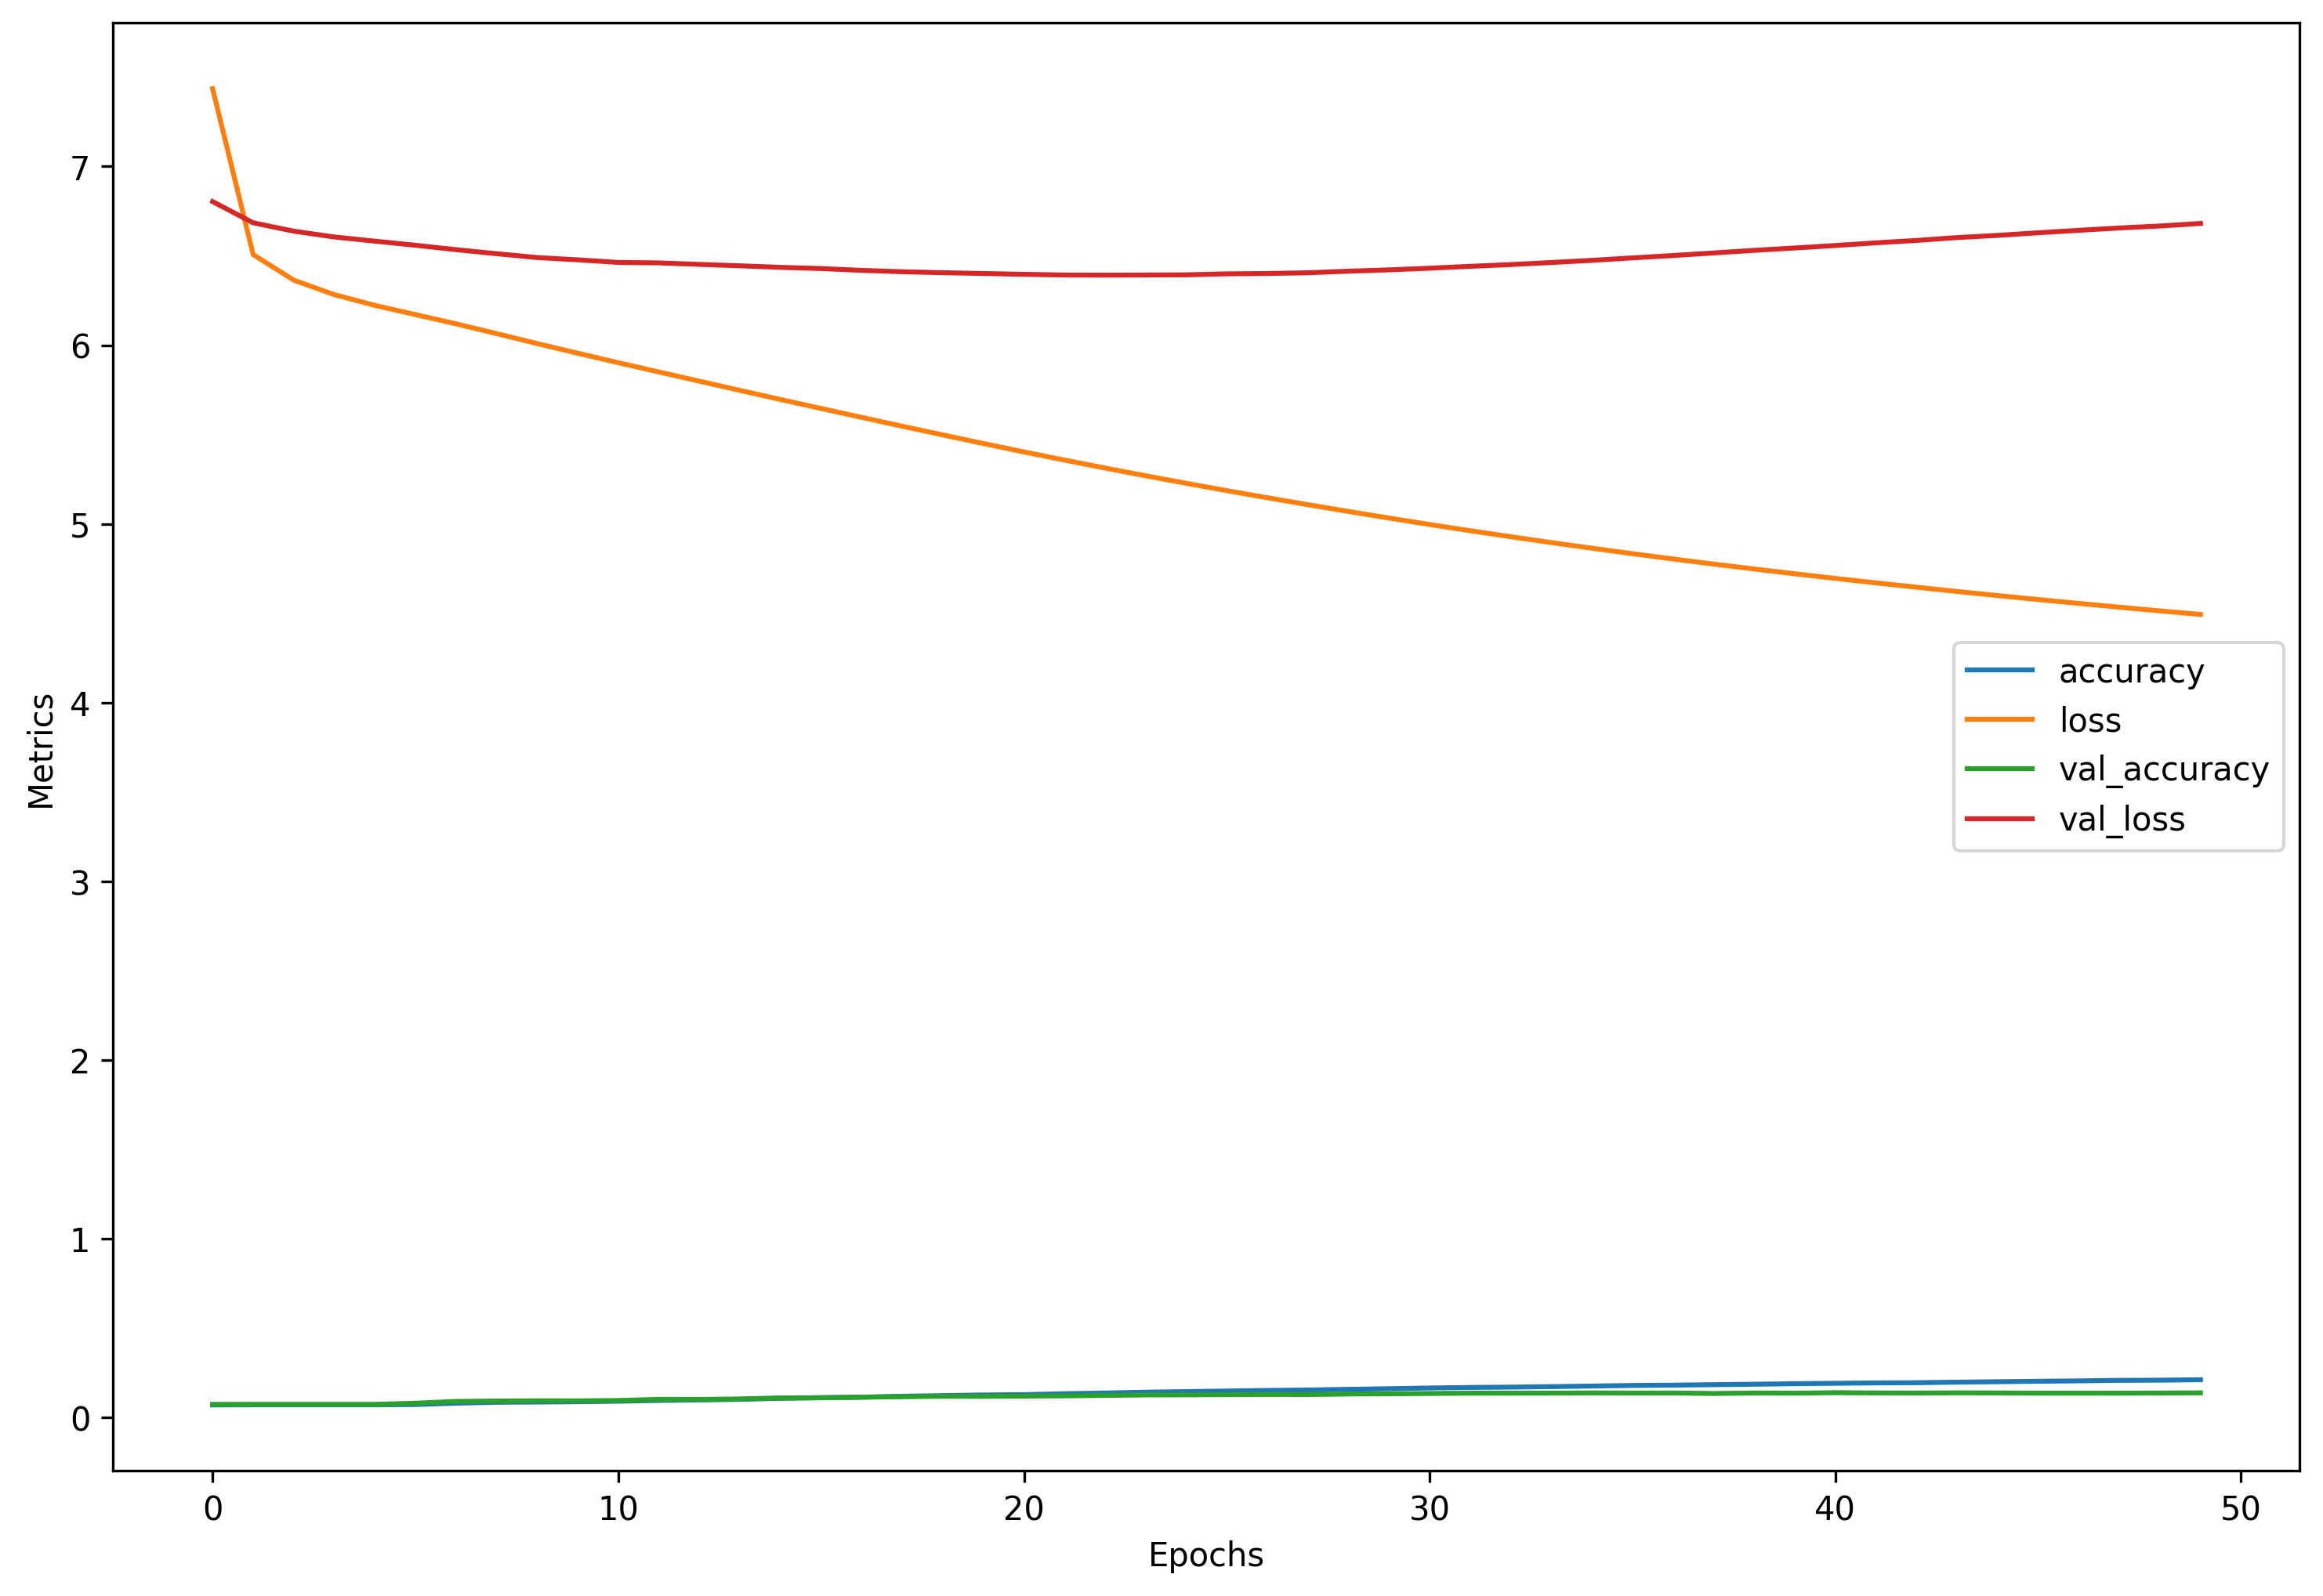

In [19]:
plt.rcParams["figure.dpi"] = 300
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()